[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\geral\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


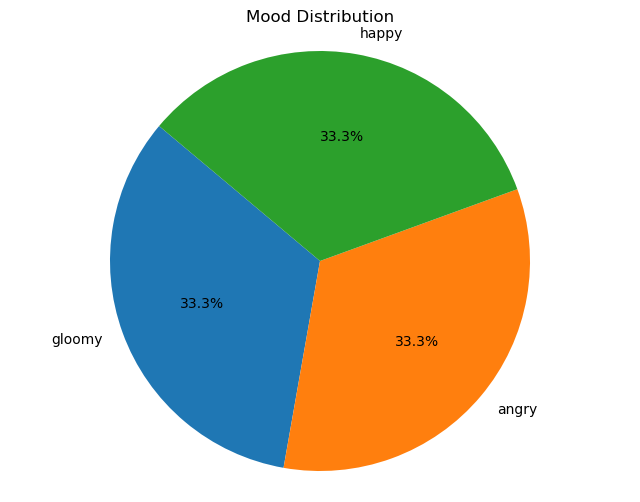

In [ ]:
import sys
import webbrowser  # Import webbrowser to open URLs
import nltk  # Import NLTK for sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QHBoxLayout, QPushButton, QLabel, QLineEdit, QListWidget, QListWidgetItem, QStackedWidget, QMainWindow, QMessageBox, QDialog
from PyQt5.QtGui import QFont
from PyQt5.QtCore import Qt, QSize
import pylast  # Import pylast for Last.fm API
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

class SignInPage(QWidget):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.initUI()

    def initUI(self):
        layout = QVBoxLayout()
        title = QLabel('MoodTunes')
        title.setAlignment(Qt.AlignCenter)
        title.setFont(QFont('Arial', 36, QFont.Bold))
        layout.addWidget(title)

        self.username_input = QLineEdit()
        self.username_input.setPlaceholderText('Username')
        layout.addWidget(self.username_input)

        self.password_input = QLineEdit()
        self.password_input.setPlaceholderText('Password')
        self.password_input.setEchoMode(QLineEdit.Password)
        layout.addWidget(self.password_input)

        sign_in_btn = QPushButton('Sign In')
        sign_in_btn.clicked.connect(self.sign_in)
        layout.addWidget(sign_in_btn)

        self.setLayout(layout)

    def sign_in(self):
        if self.username_input.text() and self.password_input.text():
            self.parent().parent().show_main_page()  # Access the grandparent to call show_main_page
        else:
            QMessageBox.warning(self, 'Error', 'Please enter both username and password')

class MoodMusicApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.initUI()
        self.initLastFM()

    def initLastFM(self):
        self.network = pylast.LastFMNetwork(
            api_key="1b7b93144b70f440a33065bdd26bc8e1",  # Replace with your Last.fm API key
            api_secret="2b8b69890467861acc8c58bfd22135cc"  # Replace with your Last.fm API secret
        )

    def initUI(self):
        self.setWindowTitle('MoodTunes')
        self.setGeometry(100, 100, 800, 600)
        self.setStyleSheet(self.dark_mode_stylesheet())  # Set initial stylesheet to dark mode

        self.stacked_widget = QStackedWidget()
        self.setCentralWidget(self.stacked_widget)

        self.sign_in_page = SignInPage(self)
        self.main_page = MainPage(self)

        self.stacked_widget.addWidget(self.sign_in_page)
        self.stacked_widget.addWidget(self.main_page)

    def show_main_page(self):
        self.stacked_widget.setCurrentWidget(self.main_page)

    def dark_mode_stylesheet(self):
        return """
        QWidget {
            background-color: #121212;
            color: #ffffff;
            font-family: 'Segoe UI', 'Roboto', 'Helvetica', 'Arial', sans-serif;
        }
        QPushButton {
            background-color: #1DB954;
            color: white;
            border: none;
            padding: 10px 20px;
            border-radius: 20px;
            font-size: 16px;
        }
        QLineEdit {
            padding: 10px;
            border: 1px solid #333333;
            border-radius: 5px;
            font-size: 16px;
            background-color: #282828;
        }
        QListWidget {
            border: 1px solid #333333;
            border-radius: 5px;
            font-size: 18px;
            background-color: #282828;
        }
        """

    def light_mode_stylesheet(self):
        return """
        QWidget {
            background-color: #ffffff;
            color: #000000;
            font-family: 'Segoe UI', 'Roboto', 'Helvetica', 'Arial', sans-serif;
        }
        QPushButton {
            background-color: #007BFF;
            color: white;
            border: none;
            padding: 10px 20px;
            border-radius: 20px;
            font-size: 16px;
        }
        QLineEdit {
            padding: 10px;
            border: 1px solid #CCCCCC;
            border-radius: 5px;
            font-size: 16px;
            background-color: #F5F5F5;
        }
        QListWidget {
            border: 1px solid #CCCCCC;
            border-radius: 5px;
            font-size: 18px;
            background-color: #F5F5F5;
        }
        """

class MainPage(QWidget):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.initUI()
        self.is_dark_mode = True  # Default to dark mode
        self.past_searches = []  # List to store past searches
        self.clicked_songs = []   # List to store clicked songs
        self.mood_logs = []       # List to store mood logs
        self.sia = SentimentIntensityAnalyzer()  # Initialize sentiment intensity analyzer

    def initUI(self):
        layout = QVBoxLayout()
        title = QLabel('How are you feeling today?')
        title.setAlignment(Qt.AlignCenter)
        title.setFont(QFont('Arial', 24, QFont.Bold))
        layout.addWidget(title)

        self.mood_input = QLineEdit()
        self.mood_input.setPlaceholderText('Enter your mood...')
        layout.addWidget(self.mood_input)

        mood_description_input = QLineEdit()
        mood_description_input.setPlaceholderText('Describe your mood (optional)...')
        layout.addWidget(mood_description_input)

        log_mood_btn = QPushButton('Log Mood')
        log_mood_btn.clicked.connect(lambda: self.log_mood(mood_description_input.text()))
        layout.addWidget(log_mood_btn)

        get_recommendations_btn = QPushButton('Get Recommendations')
        get_recommendations_btn.clicked.connect(self.get_recommendations)
        layout.addWidget(get_recommendations_btn)

        self.recommendations_list = QListWidget()
        self.recommendations_list.itemClicked.connect(self.open_youtube_search)
        self.recommendations_list.setIconSize(QSize(60, 60))
        layout.addWidget(self.recommendations_list)

        # Create a horizontal layout for the buttons
        button_layout = QHBoxLayout()

        # Button to toggle light/dark mode
        toggle_mode_btn = QPushButton('Toggle Light/Dark Mode')
        toggle_mode_btn.setFixedSize(250, 50)  # Set a larger size for the toggle button
        toggle_mode_btn.clicked.connect(self.toggle_mode)
        button_layout.addWidget(toggle_mode_btn)

        # Button to view past searches
        view_past_searches_btn = QPushButton('View Past Searches')
        view_past_searches_btn.setFixedSize(200, 50)  # Keep the size for the past searches button
        view_past_searches_btn.clicked.connect(self.view_past_searches)
        button_layout.addWidget(view_past_searches_btn)

        # Button for mood analysis
        analyze_mood_btn = QPushButton('Analyze Mood')
        analyze_mood_btn.setFixedSize(200, 50)  # Set a size for the analyze mood button
        analyze_mood_btn.clicked.connect(self.analyze_moods)
        button_layout.addWidget(analyze_mood_btn)

        # Add the button layout to the main layout
        layout.addLayout(button_layout)

        self.setLayout(layout)

    def log_mood(self, description):
        mood = self.mood_input.text().lower()
        if mood:
            self.mood_logs.append((mood, description))  # Log the mood and description
            self.mood_input.clear()  # Clear the input field
            QMessageBox.information(self, 'Mood Logged', f'Mood: {mood}\nDescription: {description}')

    def analyze_moods(self):
        if not self.mood_logs:
            QMessageBox.information(self, 'Mood Analysis', 'No moods logged yet.')
            return

        mood_count = {}
        for mood, description in self.mood_logs:
            if mood in mood_count:
                mood_count[mood] += 1
            else:
                mood_count[mood] = 1

            # Perform sentiment analysis on the description
            sentiment_score = self.sia.polarity_scores(description)
            mood_count[mood] += sentiment_score['compound']  # Adjust mood count based on sentiment

        # Create a pie chart for mood distribution
        moods = list(mood_count.keys())
        counts = list(mood_count.values())

        plt.figure(figsize=(8, 6))
        plt.pie(counts, labels=moods, autopct='%1.1f%%', startangle=140)
        plt.title('Mood Distribution')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()

        # Example analysis: Identify the most common mood
        most_common_mood = max(mood_count, key=mood_count.get)
        suggestion = self.suggest_improvement(most_common_mood)

        QMessageBox.information(self, 'Mood Analysis',
                                f'Most Common Mood: {most_common_mood}\nSuggestion: {suggestion}')

    def suggest_improvement(self, mood):
        suggestions = {
            'happy': 'Keep doing what makes you happy!',
            'sad': 'Consider talking to a friend or practicing self-care.',
            'anxious': 'Try some deep breathing exercises or take a short walk.',
            'angry': 'Consider writing down your thoughts or practicing mindfulness.',
        }
        return suggestions.get(mood, 'Keep tracking your moods for better insights!')

    def toggle_mode(self):
        self.is_dark_mode = not self.is_dark_mode  # Toggle the mode
        if self.is_dark_mode:
            self.parent().parent().setStyleSheet(self.parent().parent().dark_mode_stylesheet())
        else:
            self.parent().parent().setStyleSheet(self.parent().parent().light_mode_stylesheet())

    def get_recommendations(self):
        user_mood = self.mood_input.text().lower()
        self.past_searches.append(user_mood)  # Store the past search
        
        # Use the Last.fm API to get song recommendations based on the user's mood
        try:
            # Search for tracks using the user's mood as the track name
            track_matches = self.parent().parent().network.search_for_track("", user_mood).get_next_page()
            self.recommendations_list.clear()
            for track in track_matches:
                # Directly access the track's artist and title
                item = QListWidgetItem(f"{track.artist.name} - {track.title}")
                self.recommendations_list.addItem(item)
        except Exception as e:
            QMessageBox.warning(self, 'Error', f'Failed to get recommendations: {str(e)}')

    def open_youtube_search(self, item):
        song_name = item.text()
        self.clicked_songs.append(song_name)  # Store the clicked song
        search_url = f'https://www.youtube.com/results?search_query={song_name.replace(" ", "+")}'
        webbrowser.open(search_url)

    def view_past_searches(self):
        dialog = QDialog(self)
        dialog.setWindowTitle("Past Searches and Clicked Songs")
        dialog.setGeometry(100, 100, 400, 300)

        layout = QVBoxLayout()
        title = QLabel("Past Searches and Clicked Songs")
        title.setAlignment(Qt.AlignCenter)
        layout.addWidget(title)

        past_searches_list = QListWidget()
        for search in self.past_searches:
            past_searches_list.addItem(search)
        layout.addWidget(past_searches_list)

        clicked_songs_list = QListWidget()
        for song in self.clicked_songs:
            clicked_songs_list.addItem(song)
        layout.addWidget(clicked_songs_list)

        close_btn = QPushButton("Close")
        close_btn.clicked.connect(dialog.close)
        layout.addWidget(close_btn)

        dialog.setLayout(layout)
        dialog.exec_()

if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = MoodMusicApp()
    ex.show()
    sys.exit(app.exec_())